In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [10]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 292700125.63it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27387676.65it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 214679230.07it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6877447.21it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [11]:
print(train_dataset.shape(),test_dataset.shape())

AttributeError: 'MNIST' object has no attribute 'shape'

Feature batch shape: torch.Size([100, 1, 28, 28])


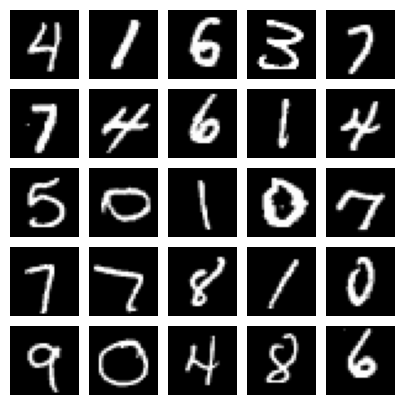

In [12]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

print(f"Feature batch shape: {image[0].size()}")

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [6]:
class ConvolutionalVAE(nn.Module):
    def __init__(self):
        super(ConvolutionalVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1), #14 x 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), #7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), #4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 16)
        )

        # Mean and variance of the latent distribution
        self.fc_mu = nn.Linear(16, 2)
        self.fc_var = nn.Linear(16, 2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.Unflatten(-1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        #h = h.view(-1, 128 * 4 * 4)
        #h=nn.flatten(h)
        mu = self.fc_mu(h)
        var = self.fc_var(h)
        return mu, var

    def decode(self, z):
        #z = z.view(-1, 128, 4, 4)
        h = self.decoder(z)
        return h

    def reparameterize(self, mu, var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, var

In [7]:
from torchsummary import summary
model = ConvolutionalVAE()
summary(model, (1,28,28))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          32,832
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                   [-1, 16]          32,784
            Linear-9                    [-1, 2]              34
           Linear-10                    [-1, 2]              34
           Linear-11                 [-1, 3136]           9,408
        Unflatten-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13          [-1, 128, 14, 14]         131,200
             ReLU-14          [-1, 128,

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
#def train(model, optimizer, epochs, device, x_dim=(28,28)):
    #model.train()
def train(model, optimizer, epochs):
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x,_) in enumerate(train_loader):
            #x = data.view(batch_size, x_dim).to(device)
            #x = data.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50)

	Epoch 1 	Average Loss:  175.3656324994783
	Epoch 2 	Average Loss:  158.8956039199447
	Epoch 3 	Average Loss:  155.6861878358462
	Epoch 4 	Average Loss:  153.6110709907137
	Epoch 5 	Average Loss:  152.19932362857367
	Epoch 6 	Average Loss:  151.14213740022433
	Epoch 7 	Average Loss:  150.27688659158494
	Epoch 8 	Average Loss:  149.58725448990506
	Epoch 9 	Average Loss:  148.9600781413032
	Epoch 10 	Average Loss:  148.47439151515547
	Epoch 11 	Average Loss:  148.04709903876252
	Epoch 12 	Average Loss:  147.60005502334621
	Epoch 13 	Average Loss:  147.2587592765286
	Epoch 14 	Average Loss:  146.92359194034327
	Epoch 15 	Average Loss:  146.57497847975793
	Epoch 16 	Average Loss:  146.26966335494052


In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float)#.to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [ ]:
plot_latent_space(model, scale=1.0)

In [ ]:
plot_latent_space(model, scale=5.0)